In [15]:
#|export
%pip install -q segment_anything opencv-python pycocotools matplotlib onnxruntime onnx ipykernel supervision wget groundingdino==0.1.0

Note: you may need to restart the kernel to use updated packages.


In [35]:
#|export
import cv2
import numpy as np
import supervision as sv
from typing import List
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import torch
import torchvision

from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor

In [3]:
#|export
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# GroundingDINO config and checkpoint
GROUNDING_DINO_CONFIG_PATH = "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "GroundingDINO/weights/groundingdino_swint_ogc.pth"

# Segment-Anything checkpoint
SAM_ENCODER_VERSION = "vit_h"
SAM_CHECKPOINT_PATH = "./sam_vit_h_4b8939.pth"

In [4]:
#|export
# Building GroundingDINO inference model
grounding_dino_model = Model(
  model_config_path=GROUNDING_DINO_CONFIG_PATH,
  model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH,
  device=DEVICE
)

/Users/antoinemacia/mambaforge/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835428/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# Building SAM Model and SAM Predictor
sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

In [22]:
#|export
# set image
image = cv2.imread("assets/diffuse.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
sam_predictor.set_image(image)

In [24]:
#|export
input_point = np.array([[1536.109375, 1149.078125]])
input_label = np.array([1])
masks, scores, logits = sam_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)


In [31]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  


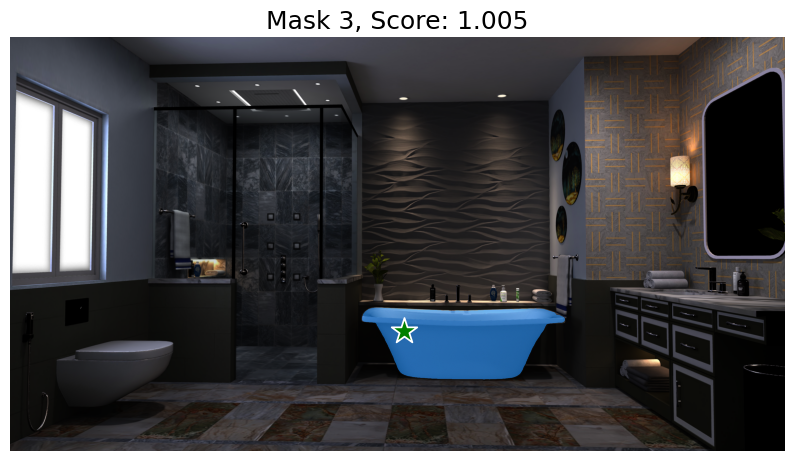

In [40]:
#|export
# Select highest scoring mask
highest_score_mask = max(zip(masks, scores), key = lambda x: x[1])
mask = highest_score_mask[0]
score = highest_score_mask[1]

# DEBUG - Display mask
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(mask, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
plt.axis('off')
plt.show()


image_mask_pil = Image.fromarray(mask)
image_mask_pil.save("assets/mask.png")